In [1]:
import os
import time
from datetime import datetime

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary


os.environ["CUDA_VISIBLE_DEVICES"] = ""
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())




cpu
0


# fMRI DATA - HCP Dataset

In [10]:
#example_filename = os.path.join('/data/HCP/rfMRI/rfMRI_REST1_LR/', '990366_rfMRI_REST1_LR_Atlas_MSMAll.dtseries.nii')
example_filename = os.path.join('/data/HCP/rfMRI/test/', '100307_rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii')

In [11]:
example_filename

'/data/HCP/rfMRI/test/100307_rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'

In [12]:
img = nib.load(example_filename)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [13]:
img.shape

(1200, 91282)

In [6]:
data = img.get_fdata()

In [7]:
data[:,0]

array([11903.87695312, 12100.14550781, 12212.72558594, ...,
       12124.0859375 , 12138.2265625 , 11836.92675781])

In [27]:
cort = np.load('/home/sd20/workspace/data/HCP_stanford/hcp_tc_npy_22/100206_cortex.npy')

In [28]:
cort.shape

(22, 1200)

array([10434.499, 10423.936, 10467.   , ..., 10543.049, 10588.694,
       10614.866])

## NETMATS



#### FIRST STEPS

In [2]:
data_path = '/home/sd20/workspace/data/HCP/'
filename = 'netmats_ICA15/Mnet1.pconn.nii'
file_path = os.path.join(data_path, filename)

In [4]:
data = nib.load(file_path)

In [7]:
print(data.shape)
print(data.get_data_dtype())

(15, 15)
float32


In [13]:
netmat_15 = data.get_fdata()


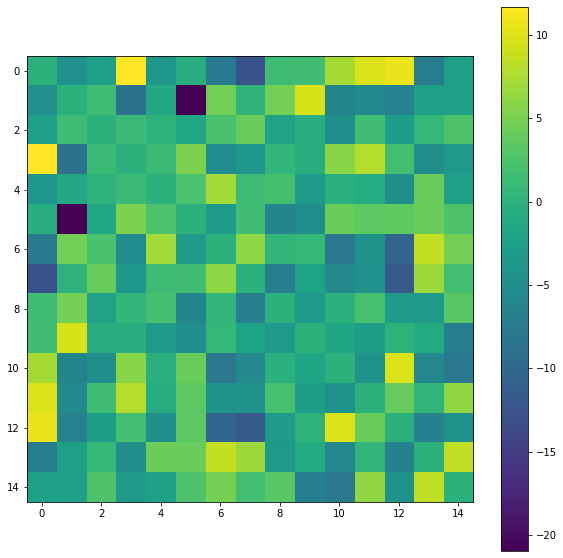

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(netmat_15)
plt.colorbar()

#### FULL CORRELATION VS PARTIAL CORRELATION - NETMAT 15

In [20]:
data_path = '/home/sd20/workspace/data/HCP/'

filename_full = 'netmats_ICA15/Mnet1.pconn.nii'
file_path_full = os.path.join(data_path, filename_full)

filename_partial = 'netmats_ICA15/Mnet2.pconn.nii'
file_path_partial = os.path.join(data_path, filename_partial)

data_full = nib.load(file_path_full)
data_partial = nib.load(file_path_partial)

netmat_15_full = data_full.get_fdata()
netmat_15_partial = data_partial.get_fdata()



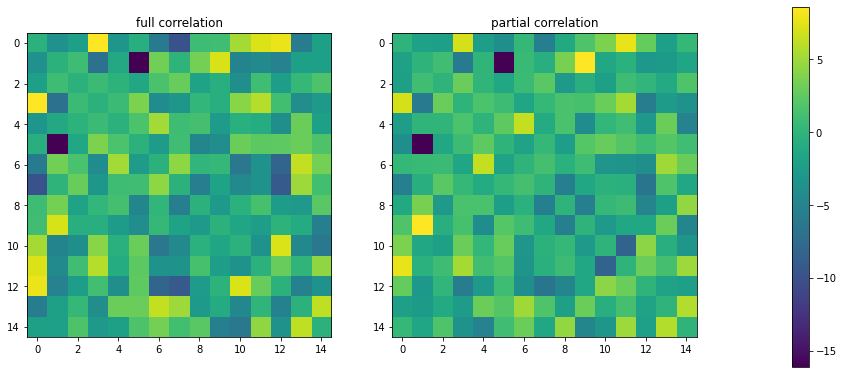

In [71]:
fig, ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(netmat_15_full)
ax[0].title.set_text("full correlation")
im = ax[1].imshow(netmat_15_partial)
ax[1].title.set_text("partial correlation")

cbaxes = fig.add_axes([1.01, 0.25, 0.02, 0.5]) 

fig.colorbar(im,cax = cbaxes)



In [72]:
data_path = '/home/sd20/workspace/data/HCP/'

filename_full = 'netmats_ICA25/Mnet1.pconn.nii'
file_path_full = os.path.join(data_path, filename_full)

filename_partial = 'netmats_ICA25/Mnet2.pconn.nii'
file_path_partial = os.path.join(data_path, filename_partial)

data_full = nib.load(file_path_full)
data_partial = nib.load(file_path_partial)

netmat_15_full = data_full.get_fdata()
netmat_15_partial = data_partial.get_fdata()

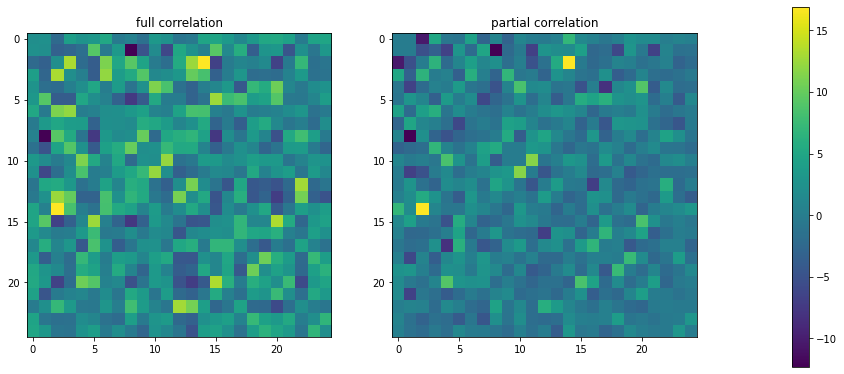

In [78]:
fig, ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(netmat_15_full)
ax[0].title.set_text("full correlation")
im = ax[1].imshow(netmat_15_partial)
ax[1].title.set_text("partial correlation")

cbaxes = fig.add_axes([1.01, 0.25, 0.02, 0.5]) 

fig.colorbar(im,cax = cbaxes)


#### LOAD TXT FILES

check if the per subject is symmetrical 

In [3]:
data_path = '/home/sd20/workspace/data/HCP/'
filename = 'netmats_ICA15/netmats1.txt'
file_path = os.path.join(data_path, filename)

df = pd.read_csv(file_path, delimiter = " ",header=None)
df



,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,0,-10.39600,1.3250,14.2230,-2.39230,7.98940,-8.3335,-6.07130,-1.8244,3.937200,...,0.86534,-0.74259,3.58890,1.99990,-12.0020,-12.5660,12.47900,-5.33980,8.4668,0
1,0,-7.05970,-8.1504,10.4730,-2.64040,0.88428,-7.0996,-9.61850,-2.7376,-0.053907,...,7.23770,2.23570,4.51860,1.51590,-7.8566,-6.9800,5.52720,-2.99760,5.1632,0
2,0,-3.21090,1.1924,15.5370,-2.70360,-2.89870,-18.0500,-29.72300,10.0080,11.842000,...,0.45386,10.04800,9.99430,-0.32299,-12.4430,-13.1390,-0.76258,-12.67400,8.3249,0
3,0,-0.77747,-13.3280,12.0090,-0.29917,-3.40240,-7.7466,-14.89300,3.8670,0.468460,...,6.70260,6.86530,-2.76830,7.78940,-11.8560,-2.8788,3.88980,-2.98890,10.5550,0
4,0,-7.64220,-1.6479,15.5950,-7.02200,4.30600,-1.2868,-6.85410,-1.8923,-0.804530,...,5.44630,8.13370,1.78790,5.43310,-5.6729,-3.6002,9.22810,1.64660,5.5657,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,0,-5.36860,-7.6809,20.6790,-4.09760,3.61610,-6.4457,-20.03100,2.5331,-0.052966,...,1.48830,-2.25540,0.26198,13.01500,-7.7512,-3.7831,10.61600,0.19387,3.3848,0
999,0,-8.45280,2.5526,13.7820,-7.28460,-2.46680,-13.7460,-20.39000,5.2821,-0.599610,...,3.64330,6.77920,6.12020,1.52980,-9.8249,-11.1950,5.72760,-5.52740,8.6371,0
1000,0,-5.73310,8.2898,10.3600,-3.88710,2.10990,-2.9118,-0.13056,-3.3337,-2.258500,...,-5.01590,1.46900,-0.68062,5.03440,-8.3454,4.6367,4.72840,4.04580,1.3631,0
1001,0,-6.98810,-6.1590,7.3031,-6.30940,1.97910,-3.5481,-19.13000,5.2046,-1.977800,...,4.00110,6.67650,-5.84130,7.86550,-5.2188,-6.4246,7.23320,1.47340,3.3242,0


In [4]:
subject_0 = df.iloc[0].values
print(subject_0.shape)
print(subject_0[1], subject_0[15])
subject_0 = np.reshape(subject_0,(15,15))
print(subject_0.shape)


(225,)
-10.396 -10.396
(15, 15)


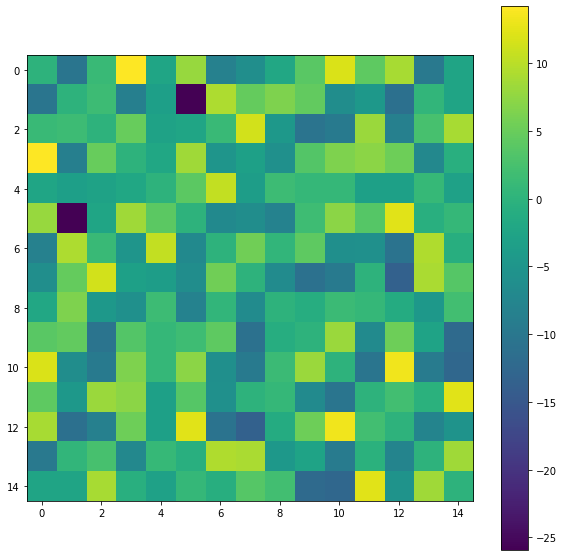

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(subject_0)
plt.colorbar()

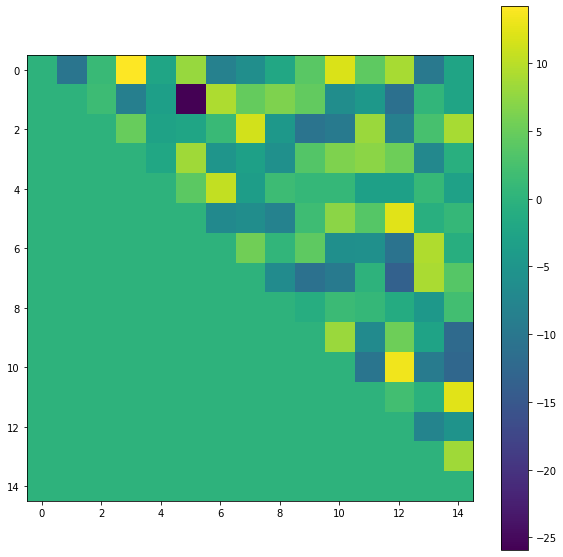

In [9]:
plt.figure(figsize=(10,10))
up_triu_subject_0 = np.triu(subject_0,k=1)
plt.imshow(up_triu_subject_0)
plt.colorbar()


#### SUBJECT INFORMATION 1003

In [36]:
data_path = '/home/sd20/workspace/data/HCP/'
filename = 'subject_information_1200.csv'
file_path = os.path.join(data_path,filename)

df = pd.read_csv(file_path)
df

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,992774,Q2,Q02,M,31-35,True,2,2,4,100.0,...,8.4,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76
1202,993675,S900,Q09,F,26-30,True,2,2,4,100.0,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76
1203,994273,S500,Q06,M,26-30,True,1,1,4,100.0,...,6.0,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76
1204,995174,S1200,Q13,M,22-25,False,1,1,2,0.0,...,3.6,88.61,64.58,3.0,50.1,117.16,117.40,1.80,0.0,1.80


In [37]:
filename = 'subjectIDs_1003.txt'
file_path = os.path.join(data_path,filename)

ids = pd.read_csv(file_path, delimiter = " ",header=None)
ids

,0
0,100206
1,100307
2,100408
3,100610
4,101006
...,...
998,992673
999,992774
1000,993675
1001,994273


In [38]:
df_1003 = df[df.Subject.isin(ids.values.reshape(-1))]
df_1003

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
5,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,992673,S900,Q12,F,31-35,True,1,2,4,100.0,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
1201,992774,Q2,Q02,M,31-35,True,2,2,4,100.0,...,8.4,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76
1202,993675,S900,Q09,F,26-30,True,2,2,4,100.0,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76
1203,994273,S500,Q06,M,26-30,True,1,1,4,100.0,...,6.0,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76


In [39]:
df_1003.to_csv(os.path.join(data_path,'subject_information_1003.csv'), index=False)

#### CREATE A PER SUBJECT CONNECTIVITY PARCELLATION TABLE

- get the 1003 subjects

- remove the underdiagonal data

- add the labels for sex classification

In [31]:
ICA_components = 300
data_path = '/home/sd20/workspace/data/HCP/'
filename = 'netmats_ICA{}/netmats1.txt'.format(ICA_components)
file_path = os.path.join(data_path, filename)

df_connectivity = pd.read_csv(file_path, delimiter = " ",header=None)
df_connectivity

,0,1,2,3,4,5,6,7,8,9,...,89990,89991,89992,89993,89994,89995,89996,89997,89998,89999
0,0,7.49720,23.35000,78.054,-4.9579,43.429,60.4470,41.4040,-7.5742,17.58300,...,5.985600,1.23560,-1.003900,-1.79980,-4.06780,-3.31760,2.231700,-0.28532,4.6379,0
1,0,-4.99950,4.73090,54.711,-6.9007,13.804,30.3770,26.1270,-2.1377,18.45000,...,0.070992,1.61880,-1.372000,-0.84560,-2.53120,-1.70270,-0.664390,-0.76610,4.5984,0
2,0,9.40280,5.24820,99.701,-12.2550,30.410,67.0210,49.9930,1.2277,1.40360,...,-1.377700,3.51790,-0.483500,-1.76140,-1.87870,-0.56904,2.101300,1.19860,4.4317,0
3,0,-28.31500,-13.18600,59.763,-24.9000,16.699,44.6980,34.0170,-8.2790,5.16900,...,3.230900,3.35450,1.727200,-0.28996,1.55230,-0.36566,1.234200,0.46160,6.1709,0
4,0,-0.14134,8.04310,63.203,-2.1901,24.454,46.9130,31.4790,5.5834,2.11680,...,0.823510,1.12190,0.094384,-0.10462,-3.42320,3.17070,0.775760,-2.84420,2.9442,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,0,-0.85452,3.24290,60.144,-6.1011,10.891,55.0160,64.7880,-9.6518,4.97660,...,3.482100,1.99840,-1.136100,-4.01700,-4.33780,2.77780,2.964200,-1.32200,7.5611,0
999,0,3.42850,10.47600,92.195,-12.6510,35.189,47.2660,52.4960,7.3938,0.57836,...,0.507100,-0.47767,0.373180,0.74475,-0.31293,-2.93160,1.213900,1.07780,4.9371,0
1000,0,4.76000,16.95700,20.941,14.9970,27.368,7.6914,8.8762,1.4107,-1.37530,...,2.702500,2.55100,0.139820,-0.50456,-0.42125,-1.09860,-1.547500,1.31420,6.4576,0
1001,0,5.93070,-0.43158,86.431,-17.4260,27.843,64.6700,66.5200,-4.5230,-5.20640,...,-0.767970,0.86741,-2.463000,0.61160,0.59027,-2.32110,-0.053458,-1.50930,5.8259,0


In [32]:
up_triu_ind = np.triu_indices(ICA_components,k=1)
up_triu_ind

(array([  0,   0,   0, ..., 297, 297, 298]),
 array([  1,   2,   3, ..., 298, 299, 299]))

In [33]:
cols = []
for i in range(len(up_triu_ind[0])):
    cols.append(up_triu_ind[0][i]*ICA_components+up_triu_ind[1][i])
len(cols)==(ICA_components*ICA_components-len(up_triu_ind[0])-ICA_components)

True

In [34]:
df_connectivity = df_connectivity[cols]

In [35]:
filename = 'subject_information_1003.csv'
file_path = os.path.join(data_path,filename)

df_1003 = pd.read_csv(file_path)
df_1003

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
2,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
3,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
4,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,992673,S900,Q12,F,31-35,True,1,2,4,100.0,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
999,992774,Q2,Q02,M,31-35,True,2,2,4,100.0,...,8.4,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76
1000,993675,S900,Q09,F,26-30,True,2,2,4,100.0,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76
1001,994273,S500,Q06,M,26-30,True,1,1,4,100.0,...,6.0,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76


In [36]:
sex_labels =  [0  if i=='M' else 1 for i in df_1003['Gender'].values]
print(sex_labels)

[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 

In [37]:
df_connectivity['sex']=sex_labels
df_connectivity

/home/sd20/anaconda3/envs/fMRI/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,1,2,3,4,5,6,7,8,9,10,...,88797,88798,88799,89097,89098,89099,89398,89399,89699,sex
0,7.49720,23.35000,78.054,-4.9579,43.429,60.4470,41.4040,-7.5742,17.58300,-2.662400,...,-0.34927,-0.658430,-3.31760,2.79060,1.33920,2.231700,1.51680,-0.28532,4.6379,0
1,-4.99950,4.73090,54.711,-6.9007,13.804,30.3770,26.1270,-2.1377,18.45000,-14.857000,...,-0.17186,-0.780040,-1.70270,-1.00820,0.36915,-0.664390,1.45510,-0.76610,4.5984,1
2,9.40280,5.24820,99.701,-12.2550,30.410,67.0210,49.9930,1.2277,1.40360,-0.461260,...,-3.81500,-3.392200,-0.56904,3.66550,1.26210,2.101300,0.78259,1.19860,4.4317,0
3,-28.31500,-13.18600,59.763,-24.9000,16.699,44.6980,34.0170,-8.2790,5.16900,0.089982,...,-0.62287,0.124290,-0.36566,-0.94756,-0.63533,1.234200,1.27270,0.46160,6.1709,0
4,-0.14134,8.04310,63.203,-2.1901,24.454,46.9130,31.4790,5.5834,2.11680,9.282800,...,-1.06850,-1.795900,3.17070,1.39460,0.79006,0.775760,0.17996,-2.84420,2.9442,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,-0.85452,3.24290,60.144,-6.1011,10.891,55.0160,64.7880,-9.6518,4.97660,-12.543000,...,-0.15140,1.257800,2.77780,0.22414,-0.47279,2.964200,-0.26596,-1.32200,7.5611,1
999,3.42850,10.47600,92.195,-12.6510,35.189,47.2660,52.4960,7.3938,0.57836,4.123800,...,2.26950,0.643660,-2.93160,0.24456,3.25640,1.213900,-0.68257,1.07780,4.9371,0
1000,4.76000,16.95700,20.941,14.9970,27.368,7.6914,8.8762,1.4107,-1.37530,-8.494300,...,-0.76169,-1.795200,-1.09860,0.55332,-0.11358,-1.547500,-0.76885,1.31420,6.4576,1
1001,5.93070,-0.43158,86.431,-17.4260,27.843,64.6700,66.5200,-4.5230,-5.20640,15.786000,...,-3.75140,0.019416,-2.32110,0.79256,0.14387,-0.053458,-0.63690,-1.50930,5.8259,0


In [38]:
#df_1003.columns.values
df_connectivity['fluid_intelligence'] = df_1003['PMAT24_A_CR']
df_connectivity

/home/sd20/anaconda3/envs/fMRI/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,1,2,3,4,5,6,7,8,9,10,...,88798,88799,89097,89098,89099,89398,89399,89699,sex,fluid_intelligence
0,7.49720,23.35000,78.054,-4.9579,43.429,60.4470,41.4040,-7.5742,17.58300,-2.662400,...,-0.658430,-3.31760,2.79060,1.33920,2.231700,1.51680,-0.28532,4.6379,0,20.0
1,-4.99950,4.73090,54.711,-6.9007,13.804,30.3770,26.1270,-2.1377,18.45000,-14.857000,...,-0.780040,-1.70270,-1.00820,0.36915,-0.664390,1.45510,-0.76610,4.5984,1,17.0
2,9.40280,5.24820,99.701,-12.2550,30.410,67.0210,49.9930,1.2277,1.40360,-0.461260,...,-3.392200,-0.56904,3.66550,1.26210,2.101300,0.78259,1.19860,4.4317,0,7.0
3,-28.31500,-13.18600,59.763,-24.9000,16.699,44.6980,34.0170,-8.2790,5.16900,0.089982,...,0.124290,-0.36566,-0.94756,-0.63533,1.234200,1.27270,0.46160,6.1709,0,23.0
4,-0.14134,8.04310,63.203,-2.1901,24.454,46.9130,31.4790,5.5834,2.11680,9.282800,...,-1.795900,3.17070,1.39460,0.79006,0.775760,0.17996,-2.84420,2.9442,1,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,-0.85452,3.24290,60.144,-6.1011,10.891,55.0160,64.7880,-9.6518,4.97660,-12.543000,...,1.257800,2.77780,0.22414,-0.47279,2.964200,-0.26596,-1.32200,7.5611,1,21.0
999,3.42850,10.47600,92.195,-12.6510,35.189,47.2660,52.4960,7.3938,0.57836,4.123800,...,0.643660,-2.93160,0.24456,3.25640,1.213900,-0.68257,1.07780,4.9371,0,14.0
1000,4.76000,16.95700,20.941,14.9970,27.368,7.6914,8.8762,1.4107,-1.37530,-8.494300,...,-1.795200,-1.09860,0.55332,-0.11358,-1.547500,-0.76885,1.31420,6.4576,1,21.0
1001,5.93070,-0.43158,86.431,-17.4260,27.843,64.6700,66.5200,-4.5230,-5.20640,15.786000,...,0.019416,-2.32110,0.79256,0.14387,-0.053458,-0.63690,-1.50930,5.8259,0,20.0


In [39]:
df_connectivity.to_csv('/home/sd20/workspace/spatio-temporal-fmri-analysis/data/netmats/ICA{}/connectivity_ICA{}.csv'.format(ICA_components,ICA_components), index=False)

## TASK

1) Prediction of sex

TO CONSIDER:

- normalisation (?)
- basic MLP model  DONE
- encode M/F with 0/1 DONE
- use a sigmoid DONE
- use two hidden layers DONE
- compare different models with the same number of neurons
- print the curve of learning on the same graph.
- training/testing/validation split + seed 
- tensorboard
- github
- validation
- folder for log
- folder with ICA_15
- validation per epoch not per iteration
- add HPs in tensorboard

#### DATALOADER

- read data csv then array

- split the data into train and test (later)

- convert to dataset + dataloader



In [12]:
data_path = '/home/sd20/workspace/data/HCP/'


In [55]:
df = pd.read_csv(os.path.join('./data/netmats/ICA15/connectivity_ICA15.csv'))
df

,1,2,3,4,5,6,7,8,9,10,...,163,164,177,178,179,193,194,209,sex,fluid_intelligence
0,-10.39600,1.3250,14.2230,-2.39230,7.98940,-8.3335,-6.07130,-1.8244,3.937200,11.94700,...,-9.1514,-12.5660,2.06270,-0.29261,12.47900,-7.88120,-5.33980,8.4668,0,20.0
1,-7.05970,-8.1504,10.4730,-2.64040,0.88428,-7.0996,-9.61850,-2.7376,-0.053907,8.25940,...,-7.4352,-6.9800,0.44969,1.80400,5.52720,-7.61250,-2.99760,5.1632,1,17.0
2,-3.21090,1.1924,15.5370,-2.70360,-2.89870,-18.0500,-29.72300,10.0080,11.842000,16.16100,...,-6.4737,-13.1390,12.00700,-6.51320,-0.76258,-10.40500,-12.67400,8.3249,0,7.0
3,-0.77747,-13.3280,12.0090,-0.29917,-3.40240,-7.7466,-14.89300,3.8670,0.468460,6.06800,...,-4.2114,-2.8788,5.98590,-1.26980,3.88980,-10.76500,-2.98890,10.5550,0,23.0
4,-7.64220,-1.6479,15.5950,-7.02200,4.30600,-1.2868,-6.85410,-1.8923,-0.804530,0.85586,...,-1.5446,-3.6002,8.57510,-0.27688,9.22810,0.18034,1.64660,5.5657,1,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,-5.36860,-7.6809,20.6790,-4.09760,3.61610,-6.4457,-20.03100,2.5331,-0.052966,3.91940,...,-7.3239,-3.7831,10.11900,-3.26570,10.61600,-8.37010,0.19387,3.3848,1,21.0
999,-8.45280,2.5526,13.7820,-7.28460,-2.46680,-13.7460,-20.39000,5.2821,-0.599610,13.76200,...,-7.7920,-11.1950,13.06800,-2.14390,5.72760,-5.64390,-5.52740,8.6371,0,14.0
1000,-5.73310,8.2898,10.3600,-3.88710,2.10990,-2.9118,-0.13056,-3.3337,-2.258500,0.68182,...,-1.5151,4.6367,5.24060,4.20020,4.72840,-1.13730,4.04580,1.3631,1,21.0
1001,-6.98810,-6.1590,7.3031,-6.30940,1.97910,-3.5481,-19.13000,5.2046,-1.977800,5.10510,...,1.5451,-6.4246,11.03100,-3.95300,7.23320,-4.39190,1.47340,3.3242,0,20.0


In [53]:
dict_input_size = {'15':105,
                    '25':300,
                    '50':1225,
                    ''}


In [5]:
df['sex'].values

array([0, 1, 0, ..., 1, 0, 1])

In [2]:
class dataLoader():

    def __init__(self, 
                 data_path,
                 num_workers,
                 batch_size,
                 label='sex',
                 random_seed=42,
                  ):
        '''
        This class is the dataloader for the connectivity data
        '''

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.data_path = data_path
        self.label = label

        # load csv

        df = pd.read_csv(self.data_path)

        # create two arrays X, y 

        X = df.iloc[:,:-2].values
        y = df[self.label].values

        # split array into train and test
        X_train, X_val, y_train, y_val = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=random_seed, 
                                                        stratify=y)
        print('shape X train {} , y train {}'.format(X_train.shape, y_train.shape))
        print('shape X val {} , y val {}'.format(X_val.shape, y_val.shape))

        # convert into tensors

        self.tensor_x_train = torch.Tensor(X_train)
        self.tensor_y_train = torch.Tensor(y_train)

        self.tensor_x_val = torch.Tensor(X_val)
        self.tensor_y_val = torch.Tensor(y_val)


    
    def getDatasets(self,):

        train_dataset = TensorDataset(self.tensor_x_train,self.tensor_y_train)
        val_dataset = TensorDataset(self.tensor_x_val,self.tensor_y_val)

        return train_dataset, val_dataset

    
    def getDataLoaders(self,):

        train_dataset,val_dataset = self.getDatasets()

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=self.batch_size,
                                                   shuffle=True,
                                                   num_workers = self.num_workers)
        valid_loader = torch.utils.data.DataLoader(val_dataset,
                                                   batch_size=self.batch_size,
                                                   shuffle=False,
                                                   num_workers = self.num_workers)

        return {"train":train_loader,"valid":valid_loader}

    
    def getInfoDataset(self,):
        
        return 0



In [3]:
loader = dataLoader(data_path = './data/netmats/ICA25/connectivity_ICA25.csv',
                        num_workers = 8,
                        batch_size = 32,
                        label ='sex',)

train_loader = loader.getDataLoaders()["train"]

shape X train (802, 300) , y train (802,)
shape X val (201, 300) , y val (201,)


In [4]:
for i, data in enumerate(train_loader):
    print(i)
    print(data[0].shape, data[1].shape)


0
torch.Size([32, 300]) torch.Size([32])
1
torch.Size([32, 300]) torch.Size([32])
2
torch.Size([32, 300]) torch.Size([32])
3
torch.Size([32, 300]) torch.Size([32])
4
torch.Size([32, 300]) torch.Size([32])
5
torch.Size([32, 300]) torch.Size([32])
6
torch.Size([32, 300]) torch.Size([32])
7
torch.Size([32, 300]) torch.Size([32])
8
torch.Size([32, 300]) torch.Size([32])
9
torch.Size([32, 300]) torch.Size([32])
10
torch.Size([32, 300]) torch.Size([32])
11
torch.Size([32, 300]) torch.Size([32])
12
torch.Size([32, 300]) torch.Size([32])
13
torch.Size([32, 300]) torch.Size([32])
14
torch.Size([32, 300]) torch.Size([32])
15
torch.Size([32, 300]) torch.Size([32])
16
torch.Size([32, 300]) torch.Size([32])
17
torch.Size([32, 300]) torch.Size([32])
18
torch.Size([32, 300]) torch.Size([32])
19
torch.Size([32, 300]) torch.Size([32])
20
torch.Size([32, 300]) torch.Size([32])
21
torch.Size([32, 300]) torch.Size([32])
22
torch.Size([32, 300]) torch.Size([32])
23
torch.Size([32, 300]) torch.Size([32])
24

In [5]:
dataloaders = loader.getDataLoaders()

#### MODEL

In [6]:
class MLP(nn.Module):

    '''
    This class defines a multi-layer perceptrons architecture
    '''

    def __init__(self,input_size,
                      hidden_size = [1024,512,32], 
                      dropout=0.5):

        super(MLP,self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.num_linear = len(hidden_size)

        ## fully connected layers
        self.fc_layers = torch.nn.ModuleDict()

        self.fc_layers['fc_layer_0'] = nn.Linear(self.input_size, self.hidden_size[0])
        for i in range(self.num_linear-1):
            self.fc_layers[f'fc_layer_{i+1}'] = nn.Linear(self.hidden_size[i],self.hidden_size[i+1])
        
        ## classification layer
        self.fc_class = nn.Linear(self.hidden_size[-1],1)

        if self.dropout:
            self.dropout = nn.Dropout(self.dropout)

        #init_weights(self)

        ## activation
        self.relu = nn.ReLU()

    def forward(self,x):

        out = x
        for i in range(self.num_linear):
            out = self.fc_layers[f'fc_layer_{i}'](out)
            out = self.relu(out)
        
        if self.dropout:
            out = self.dropout(out)
        out = self.fc_class(out)
        return out



In [7]:
net = MLP(input_size=300,
          hidden_size=[16],
          dropout=0.5)

net

MLP(
  (fc_layers): ModuleDict(
    (fc_layer_0): Linear(in_features=300, out_features=16, bias=True)
  )
  (fc_class): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

#### Optimiser, Loss and Training parameters

In [98]:
nbr_components = 25

input_size = 300
hidden_size =[16]
dropout = 0.5
batch_size = 32


n_epochs = 20
lr = 1e-4

# loaders
loader = dataLoader(data_path = './data/netmats/ICA{}/connectivity_ICA{}.csv'.format(nbr_components,nbr_components),
                        num_workers = 8,
                        batch_size = 32,
                        label ='sex',)

dataloaders = loader.getDataLoaders()

# network
net = MLP(input_size,
          hidden_size,
          dropout)

#loss
loss = nn.BCEWithLogitsLoss()

#optimiser
optimiser = torch.optim.Adam(net.parameters(), lr=lr)

#lr scheduler

#metrics to store during training
metrics = {'loss_train': [], 'loss_valid': [], 
           'acc_train': [], 'acc_valid':[]}


shape X train (802, 300) , y train (802,)
shape X val (201, 300) , y val (201,)


### logging

1) save parameters

2) create folder for log tensorboard

In [99]:
path = '/home/sd20/workspace/spatio-temporal-fmri-analysis'
date = datetime.today().strftime('%Y-%m-%d')
print(date)

# folder date
folder_to_save_model = os.path.join(path,'logs', date)
try:
    os.mkdir(folder_to_save_model)
    print('Creating folder: {}'.format(folder_to_save_model))
except OSError:
    print('folder already exist: {}'.format(folder_to_save_model))

date = datetime.today().strftime('%H:%M:%S')
print(date)

# folder ICA
folder_to_save_model = os.path.join(folder_to_save_model,'ICA_{}'.format(nbr_components))

# folder time
folder_to_save_model = os.path.join(folder_to_save_model,date)
try:
    os.mkdir(folder_to_save_model)
    print('Creating folder: {}'.format(folder_to_save_model))
except OSError:
    print('folder already exist: {}'.format(folder_to_save_model))




# tensorboard 
writer = SummaryWriter(log_dir=folder_to_save_model)



2021-05-18
folder already exist: /home/sd20/workspace/spatio-temporal-fmri-analysis/logs/2021-05-18
11:41:31
Creating folder: /home/sd20/workspace/spatio-temporal-fmri-analysis/logs/2021-05-18/ICA_25/11:41:31


In [100]:
f = open(os.path.join(folder_to_save_model,'log.txt'),"w+")

# logging the hyperparameters

f.write("Batch size: {} \n".format(batch_size))
f.write("Epoch: {} \n".format(n_epochs))
f.write("Learning rate: {} \n".format(lr))
f.write("Optimiser: {} \n".format(optimiser))
f.close()


In [101]:
date = datetime.today().strftime('%H:%M:%S')
date

'11:41:32'

In [102]:
net

MLP(
  (fc_layers): ModuleDict(
    (fc_layer_0): Linear(in_features=300, out_features=16, bias=True)
  )
  (fc_class): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [103]:
writer.add_graph(net, torch.rand(batch_size,300))

#### TRAINING & VALIDATION LOOPS

In [104]:
best_train_epoch = 0.0
best_val_epoch = 0.0

for epoch in range(0, n_epochs):
    print('#'*50)

    # Print learning rate for each epoch -- good for when you have a LR scheduler
    #scheduler.step()
    #lr = optim.param_groups[0]['lr']
    #print('lr = %.7f' % lr)

    # Save time to calculate how long it took
    start_time = time.time()

    # Append emtpy list so that each epoch has a list of values
    for key_ in metrics.keys():
        metrics[key_].append([])

    predictions_val = []
    gt_val =[]
    epoch_acc_val = []
    epoch_acc_train = []


    # Go through each phase TRAIN/VALID
    #####################################################  
    for phase in ['train','valid']:

        total_correct = 0.0
        total_size = 0.0

        # Go through each data point in either train or validation
        #####################################################  
        for i, (inputs, labels) in enumerate(dataloaders[phase]):

            
            # Calculates step
            length_dataloader = len(dataloaders[phase])
            step = epoch * length_dataloader + i + 1

            # Fetch batch of data
            ##################################################
            # Image data
            inputs = inputs.to(device)
            
            # Label data
            lab_gt = labels.to(device)

            # TRAIN
            ##################################################
            if phase == 'train':

                optimiser.zero_grad()

                outputs =  net(inputs).squeeze()  

                current_loss =  loss(outputs,labels) 

                #####
                metrics['loss_train'][-1].append(current_loss.item())
                writer.add_scalar('loss/train', current_loss.item(), epoch*length_dataloader+i)

                predicted = torch.round(torch.nn.functional.sigmoid(outputs))
                correct_batch = (predicted == lab_gt).sum().item()

                total_correct += correct_batch
                total_size += lab_gt.shape[0]

                accuracy_batch = correct_batch / lab_gt.shape[0]
                epoch_acc_train.append(accuracy_batch*100.)
                metrics['acc_train'][-1].append(accuracy_batch * 100.)     
                writer.add_scalar('accuracy/train', accuracy_batch * 100., epoch*length_dataloader+i)

                #####
                current_loss.backward() 

                optimiser.step()
        
            if phase == 'valid':

                net.eval()

                with torch.no_grad():

                    outputs_val = net(inputs).squeeze()

                    current_loss = loss(outputs_val, lab_gt)

                    metrics['loss_valid'][-1].append(current_loss.item())
                    writer.add_scalar('loss/val', current_loss.item(), epoch*length_dataloader+i)

                    predicted_val = torch.round(torch.nn.functional.sigmoid(outputs_val))
                    predictions_val = predictions_val + list(predicted_val.numpy())
                    gt_val = gt_val + list(lab_gt.numpy())

                    correct_batch = (predicted_val == lab_gt).sum().item()
                    total_correct += correct_batch
                    total_size += lab_gt.shape[0]

                    accuracy_batch = correct_batch / lab_gt.shape[0]
                    epoch_acc_val.append(accuracy_batch*100.)
                    metrics['acc_valid'][-1].append(accuracy_batch * 100.)  
                    writer.add_scalar('accuracy/val', accuracy_batch * 100., epoch*length_dataloader+i)   

        if phase =='valid':
            if np.mean(epoch_acc_val)>best_val_epoch:
                best_val_epoch=np.mean(epoch_acc_val)
            writer.add_scalar('accuracy_best_epoch/val',best_val_epoch, epoch)   
        if phase =='train':
            if np.mean(epoch_acc_train)>best_train_epoch:
                best_train_epoch=np.mean(epoch_acc_train)
            writer.add_scalar('accuracy_best_epoch/train',best_train_epoch, epoch)   


        # PRINT STATS
        ###################################################
        print(total_correct, total_size)
        accuracy = total_correct / total_size

        time_elapsed = time.time() - start_time
        print("%s Epoch: %3d | Acc:  %3d| Loss:%.4e | %.0fm %.2fs" %
                (phase.upper(), epoch, accuracy * 100,
                current_loss.item(), time_elapsed // 60, time_elapsed % 60))

        print('')


##################################################
395.0 802.0
TRAIN Epoch:   0 | Acc:   49| Loss:3.1484e-01 | 0m 0.27s

/home/sd20/anaconda3/envs/fMRI/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
110.0 201.0
VALID Epoch:   0 | Acc:   54| Loss:7.5958e-01 | 0m 0.45s

##################################################
467.0 802.0
TRAIN Epoch:   1 | Acc:   58| Loss:8.0940e-01 | 0m 0.24s

108.0 201.0
VALID Epoch:   1 | Acc:   53| Loss:7.3141e-01 | 0m 0.43s

##################################################
470.0 802.0
TRAIN Epoch:   2 | Acc:   58| Loss:7.0708e-01 | 0m 0.24s

112.0 201.0
VALID Epoch:   2 | Acc:   55| Loss:7.3946e-01 | 0m 0.44s

##################################################
487.0 802.0
TRAIN Epoch:   3 | Acc:   60| Loss:4.1705e-01 | 0m 0.21s

115.0 201.0
VALID Epoch:   3 | Acc:   57| Loss:7.2059e-01 

In [114]:
writer.add_hparams(hparam_dict={'batch_size':batch_size}, metric_dict={'loss':np.array(metrics['loss_train'][0][0]).reshape(-1)})

In [112]:
len(metrics['loss_train'])

20